<a href="https://colab.research.google.com/github/Rhitabrat/deep-learning-CS510/blob/main/hw1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 1<br>
CS 510: Deep Learning<br>
Winter 2022<br>
Instructor: Suresh Singh

In [1]:
# import required libraries
import numpy as np
import pandas as pd
from typing import List, Any
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms

##Load Fashion MNIST data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_file_path = "/content/drive/MyDrive/PSU/Winter-2022/Deep Learning/Assignments/Assignment 1/FMNIST Dataset/fashion-mnist_train.csv"
test_file_path = "/content/drive/MyDrive/PSU/Winter-2022/Deep Learning/Assignments/Assignment 1/FMNIST Dataset/fashion-mnist_test.csv"

data_train = pd.read_csv(train_file_path)
data_test = pd.read_csv(test_file_path)

# let's see how our data looks like
data_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,0,83,155,136,116,148,110,118,67,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,118,...,199,165,108,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,159,6,91,0,0,85,159,0,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,0,1,0,0,87,114,77,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,...,228,229,231,231,218,230,255,0,0,0,0,0,0,0,0,0,0,0,116,140,147,166,176,174,173,173,174,173,177,164,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


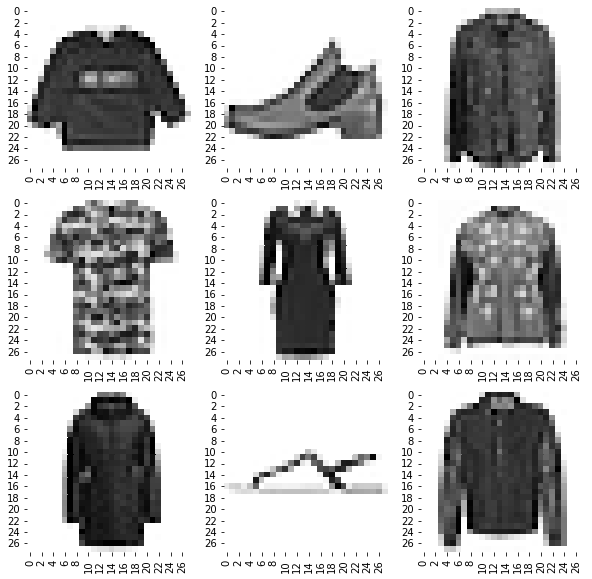

In [4]:
# visualizing some of the images

fig = plt.figure(figsize=(10,10))
for i in range(1,10):
    fig.add_subplot(3,3,i)
    sns.heatmap(np.array(data_train.iloc[i-1,1:]).reshape(28,28), cbar=False, cmap='Greys');

In [5]:
# getting the data ready for transforming
class FashionMNIST(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.labels = data.label.values
        self.images = data.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [6]:
# normalize the data and loading them for our model
data = pd.read_csv(train_file_path)
mean = np.array(data.iloc[:,1:]).flatten().mean()
std  = np.array(data.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_test  = FashionMNIST(data_test,transform=transf)
data_train = FashionMNIST(data_train,transform=transf)

## Neural Network

In [7]:
# global variables

INPUT_SIZE = 784
OUTPUT_SIZE = 10

In [8]:
# create a class that implements a fully connected feed forward network

class NNetwork(torch.nn.Module):

    def __init__(self, hidden_size: List, activation):
        super().__init__()
        self.hidden_size = hidden_size
        self.activation = activation

        modules = []
        modules.append(nn.Linear(in_features=INPUT_SIZE, out_features=hidden_size[0]))
        modules.append(self.activation)

        for i in range(len(hidden_size) - 1):
            modules.append(nn.Linear(in_features=hidden_size[i], out_features=hidden_size[i + 1]))
            modules.append(self.activation)

        modules.append(nn.Linear(in_features=hidden_size[len(hidden_size) - 1], out_features=OUTPUT_SIZE))

        self.module_list = nn.ModuleList(modules=modules)

    def forward(self, x):

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        for f in self.module_list:
            x = x.to(device)
            x = f(x)

        x = x.to(device)
        return x

In [9]:
# create test and train methods for testing and training the fully connected network

class FashionModel():

    def __init__(self, data_train, data_test, batch_size: int ) -> None:
        self.model = None
        self.params = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.loss_train = []
        self.loss_test = []
        self.batch_size = batch_size
        self.criterion = nn.CrossEntropyLoss()
        self.data_train = data_train
        self.data_test = data_test


    def train(self, hidden_size: List, activation: Any, learn_rate: float, momentum: float, epochs: int) -> None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.model = NNetwork(hidden_size=hidden_size, activation=activation)
        self.model.to(device)

        print(f"Hidden Layers: {hidden_size}")
        print(f"Learning Rate: {learn_rate}")
        print(f"Activation:    {activation.__str__()}")
        print(f"Batch Size:    {self.batch_size}")
        print(f"Epochs:        {epochs}")
        print('~' * 85)

        self.train_loader = torch.utils.data.DataLoader(dataset=self.data_train, batch_size=self.batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=self.data_test, batch_size=self.batch_size, shuffle=True)

        optimizer = torch.optim.SGD(params=self.model.parameters(), lr=learn_rate, momentum=momentum)

        for epoch in range(1, epochs + 1):
            for batch_id, (image, label) in enumerate(self.train_loader):

                image = image.view(image.shape[0],-1)
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                image = image.to(device)
                label = label.to(device)
                output = self.model(image)
                loss = self.criterion(output, label)
                loss = loss.to()
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=2.0, norm_type=2)
                optimizer.step()

            print(f"Epoch {epoch}/{epochs}  Training Loss: {loss.item():.4f}   ", end=' ')
            self.loss_train.append(loss.item())
            self.test()

        for i in self.model.parameters():
            self.params.append(i)

    def test(self) -> None:

        batch_length = len(self.test_loader)
        with torch.no_grad():
            correct = 0
            total = 0
            for batch_id, (image, label) in enumerate(self.test_loader, start=1):
                image = image.view(image.shape[0], -1)
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                image = image.to(device)
                label = label.to(device)
                outputs = self.model(image)

                if (batch_id / batch_length == 1):
                    loss = self.criterion(outputs, label)
                    self.loss_test.append(loss.item())
                    print(f"Testing Loss: {loss.item():.4f}   ", end=' ')

                predicted = torch.argmax(input=outputs, dim=1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

        accuracy = 100 * correct / total
        self.test_accuracy.append(accuracy)
        print(f"Testing Accuracy: {accuracy}%")

#Visualization

In [15]:
plt.rcParams['figure.figsize'] = [20, 5]

def display_model_visuals(model, title, hidden_size):

    # plot accuracy 
    plt.subplot(1,3,1)
    param_title = f"Hidden: {hidden_size}, batch: {model.batch_size}, η: {learn_rate}, φ: {activation.__str__()}"
    plt.plot(np.arange(epochs), model.test_accuracy, label='Test Accuracy')
    plt.title(f"{title}: Accuracy\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(np.arange(len(model.test_accuracy)), np.arange(1, len(model.test_accuracy) + 1))
    plt.legend();

    # plot cross-entropy
    plt.subplot(1,3,2)
    param_title = f"Hidden: {hidden_size}, batch: {model.batch_size}, η: {learn_rate}, φ: {activation.__str__()}"
    plt.plot(np.arange(epochs), model.loss_train, label='Train Loss')
    plt.plot(np.arange(epochs), model.loss_test, label='Test Loss')
    plt.title(f"{title}: Cross Entropy Loss\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(np.arange(len(model.loss_test)), np.arange(1, len(model.loss_test) + 1))
    plt.legend();

    # create confusion matrix
    nb_classes = 10
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (image, classes) in enumerate(model.test_loader):
            image = image.view(image.shape[0], -1)
            outputs = model.model(image)
            _, preds = torch.max(outputs, dim=1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    cols = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag",
            "Ankle Boot"]
    plt.subplot(1,3,3)
    plt.title(f"{title}: Confusion Matrix\n{param_title}")
    sns.heatmap(pd.DataFrame(np.array(confusion_matrix), columns=cols, index=cols), cmap='Greys', annot=True, fmt='g');
    
    plt.show()

## Experiment 1 [Qn 2a]

Hidden Layers: [1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/2  Training Loss: 1.0220    Testing Loss: 1.2234    Testing Accuracy: 58.21%
Epoch 2/2  Training Loss: 0.6113    Testing Loss: 1.5341    Testing Accuracy: 60.17%


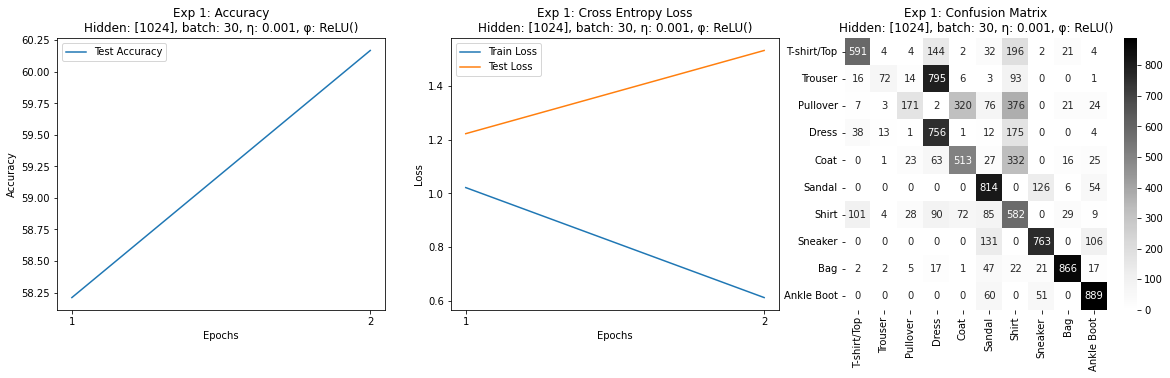

In [16]:
hidden_size = [1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 2

model_1 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_1.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

display_model_visuals(model=model_1, hidden_size=[1024], title="Exp 1")

##Experiment 2 [Qn 2a]

Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/2  Training Loss: 0.8721    Testing Loss: 0.9001    Testing Accuracy: 56.67%
Epoch 2/2  Training Loss: 0.6666    Testing Loss: 1.3201    Testing Accuracy: 58.75%


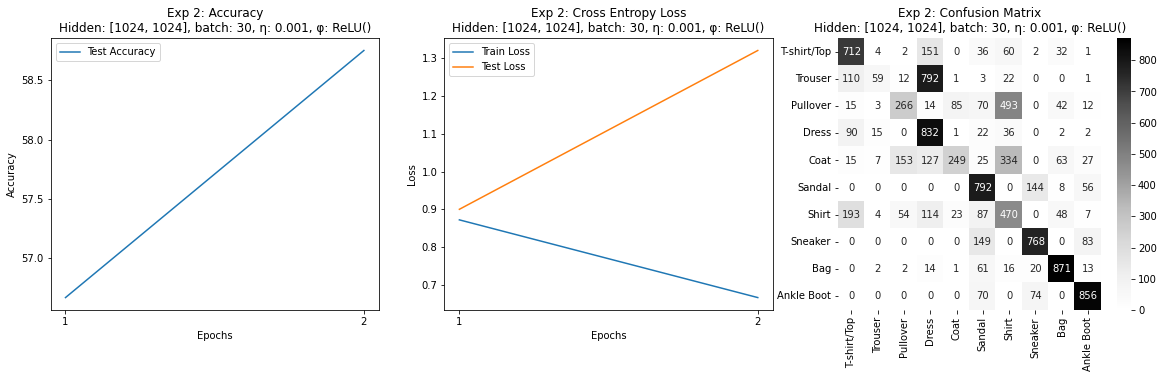

In [17]:
hidden_size = [1024, 1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 2

model_2 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_2.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

display_model_visuals(model=model_2, hidden_size=[1024,1024], title="Exp 2")

## Experiment 3 [Qn 3]

CASE: 01
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 1
Activation:    ReLU()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 26.74%
Epoch 2/5  Training Loss: 2.8611    Testing Loss: 2.4335    Testing Accuracy: 35.14%
Epoch 3/5  Training Loss: 3.4684    Testing Loss: 1.6265    Testing Accuracy: 33.64%
Epoch 4/5  Training Loss: 2.0859    Testing Loss: 2.8376    Testing Accuracy: 32.7%
Epoch 5/5  Training Loss: 2.0202    Testing Loss: 1.2345    Testing Accuracy: 24.78%


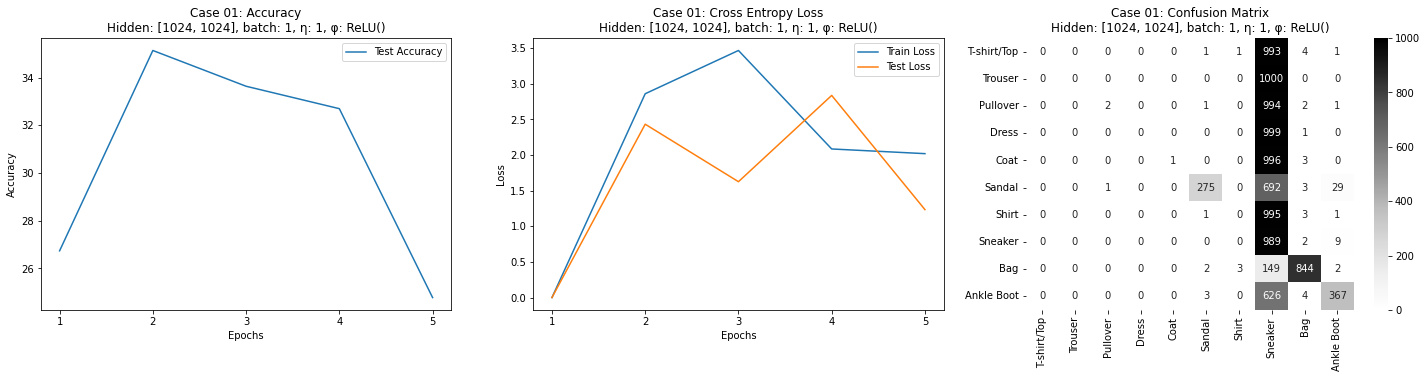

CASE: 02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 85.29%
Epoch 2/5  Training Loss: 0.0066    Testing Loss: 1.6488    Testing Accuracy: 87.6%
Epoch 3/5  Training Loss: 0.0000    Testing Loss: 0.0662    Testing Accuracy: 88.36%
Epoch 4/5  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 88.42%
Epoch 5/5  Training Loss: 1.0844    Testing Loss: 0.0002    Testing Accuracy: 89.06%


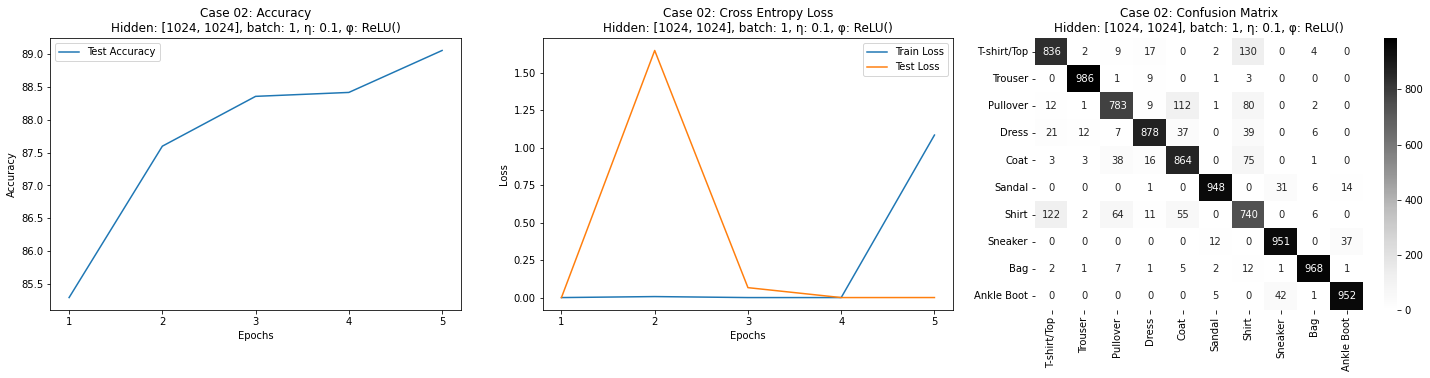

CASE: 03
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.0047    Testing Loss: 0.0002    Testing Accuracy: 85.21%
Epoch 2/5  Training Loss: 0.0001    Testing Loss: 0.0000    Testing Accuracy: 85.32%
Epoch 3/5  Training Loss: 0.0000    Testing Loss: 0.0014    Testing Accuracy: 87.9%
Epoch 4/5  Training Loss: 0.0011    Testing Loss: 0.0000    Testing Accuracy: 88.22%
Epoch 5/5  Training Loss: 0.0003    Testing Loss: 0.9151    Testing Accuracy: 88.76%


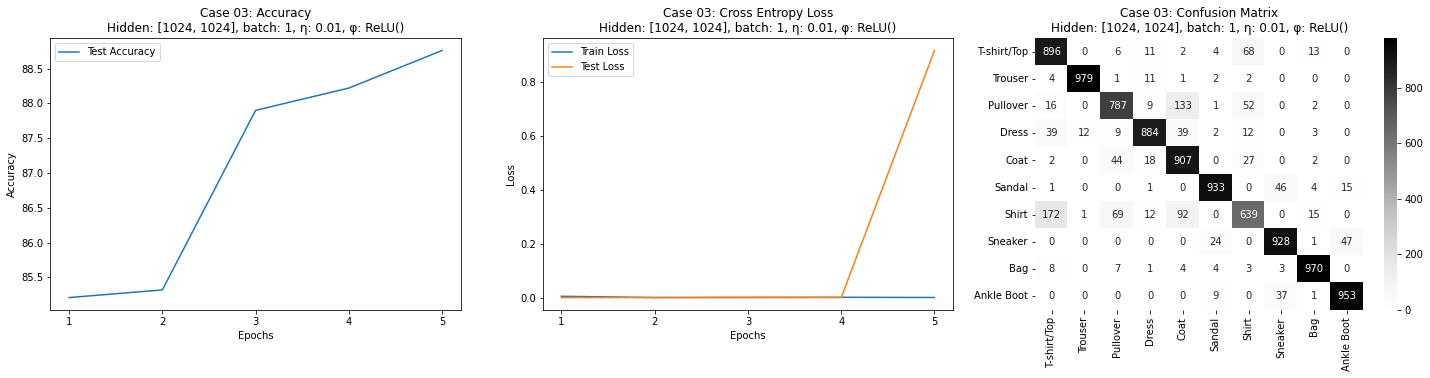

CASE: 04
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.0005    Testing Loss: 0.0001    Testing Accuracy: 78.19%
Epoch 2/5  Training Loss: 0.0030    Testing Loss: 11.8035    Testing Accuracy: 81.4%
Epoch 3/5  Training Loss: 4.0932    Testing Loss: 0.0000    Testing Accuracy: 82.83%
Epoch 4/5  Training Loss: 0.0009    Testing Loss: 1.1122    Testing Accuracy: 83.67%
Epoch 5/5  Training Loss: 0.0166    Testing Loss: 0.0000    Testing Accuracy: 84.35%


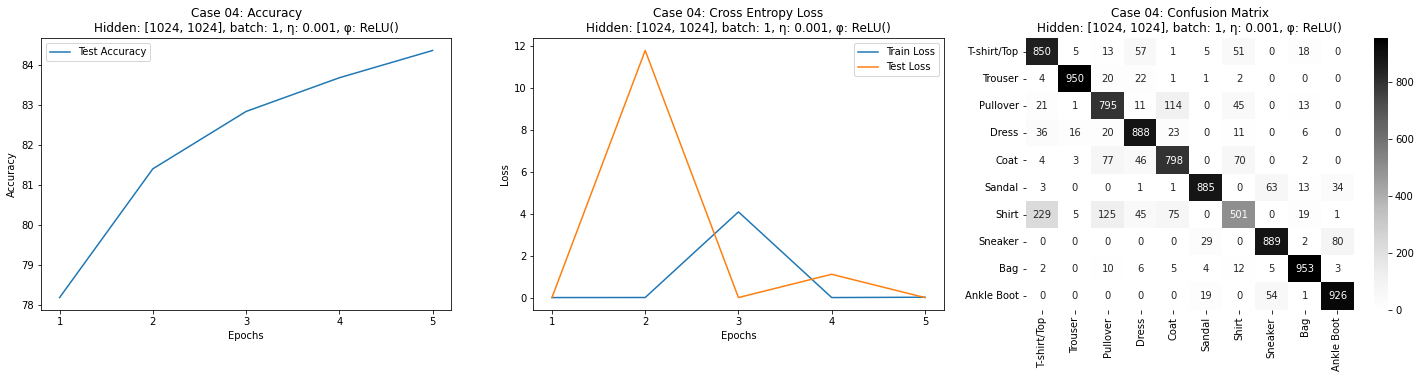

CASE: 05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.0222    Testing Loss: 0.0386    Testing Accuracy: 73.68%
Epoch 2/5  Training Loss: 0.0003    Testing Loss: 0.0002    Testing Accuracy: 78.58%
Epoch 3/5  Training Loss: 0.0339    Testing Loss: 0.0000    Testing Accuracy: 71.51%
Epoch 4/5  Training Loss: 0.0033    Testing Loss: 0.0000    Testing Accuracy: 78.99%
Epoch 5/5  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 77.49%


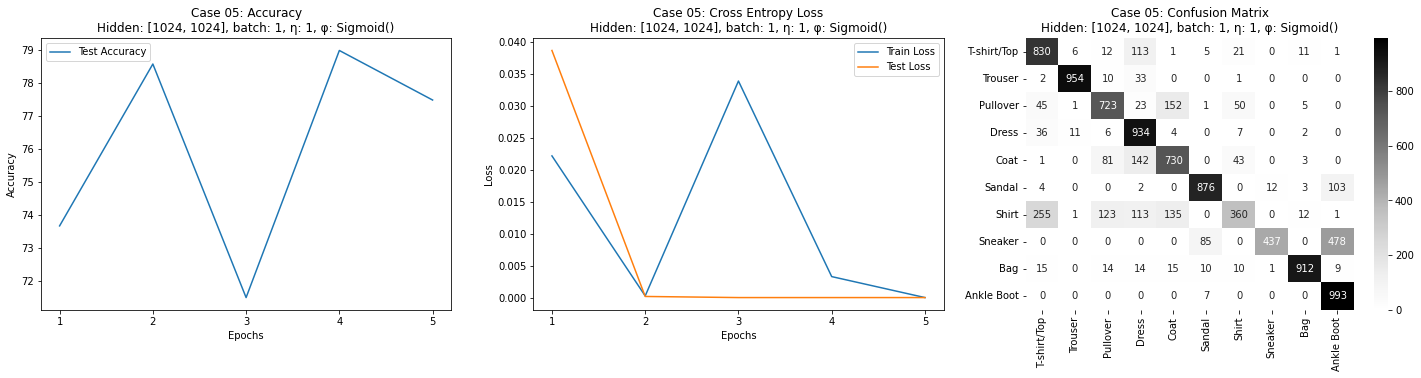

CASE: 06
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.5643    Testing Loss: 0.0274    Testing Accuracy: 84.66%
Epoch 2/5  Training Loss: 1.7567    Testing Loss: 2.7121    Testing Accuracy: 86.04%
Epoch 3/5  Training Loss: 0.0005    Testing Loss: 0.0000    Testing Accuracy: 87.45%
Epoch 4/5  Training Loss: 0.0022    Testing Loss: 0.0400    Testing Accuracy: 87.91%
Epoch 5/5  Training Loss: 0.0021    Testing Loss: 0.0047    Testing Accuracy: 88.2%


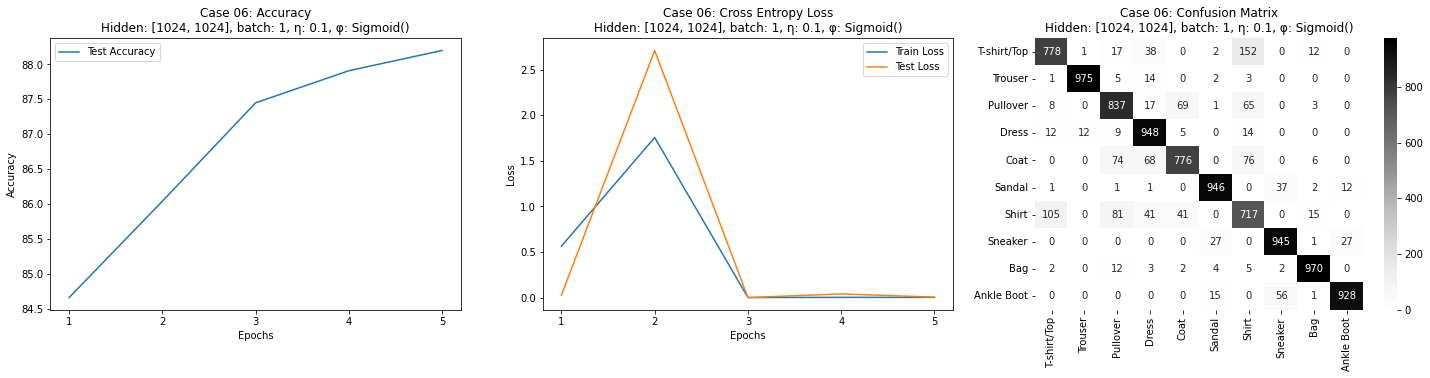

CASE: 07
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.8544    Testing Loss: 0.0163    Testing Accuracy: 76.0%
Epoch 2/5  Training Loss: 0.0004    Testing Loss: 0.0010    Testing Accuracy: 81.69%
Epoch 3/5  Training Loss: 0.0060    Testing Loss: 0.0001    Testing Accuracy: 83.47%
Epoch 4/5  Training Loss: 0.0001    Testing Loss: 0.4703    Testing Accuracy: 84.13%
Epoch 5/5  Training Loss: 0.5189    Testing Loss: 0.0000    Testing Accuracy: 84.83%


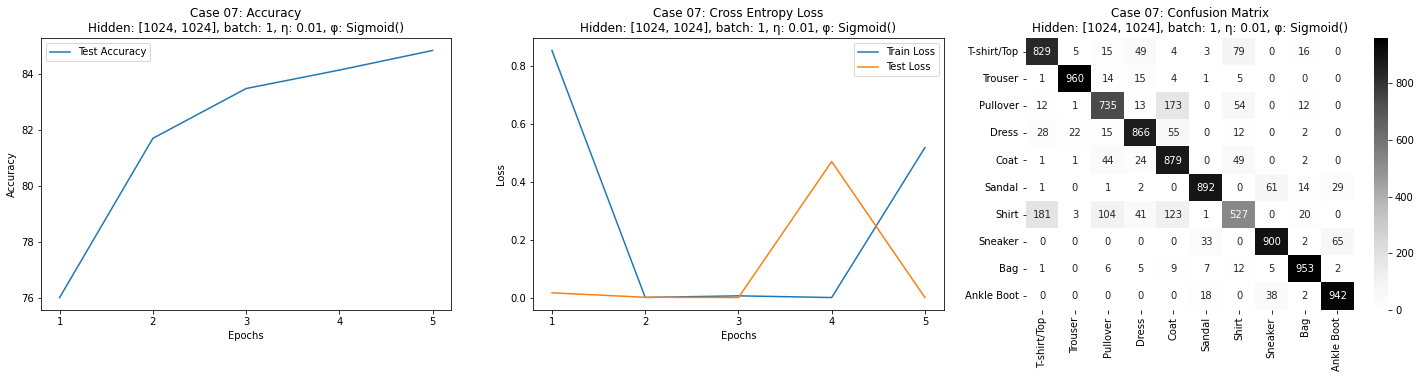

CASE: 08
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 1.9628    Testing Loss: 1.9921    Testing Accuracy: 42.36%
Epoch 2/5  Training Loss: 0.6082    Testing Loss: 0.8483    Testing Accuracy: 49.59%
Epoch 3/5  Training Loss: 1.8965    Testing Loss: 0.2908    Testing Accuracy: 57.08%
Epoch 4/5  Training Loss: 0.0012    Testing Loss: 0.4430    Testing Accuracy: 68.82%
Epoch 5/5  Training Loss: 0.0176    Testing Loss: 0.0226    Testing Accuracy: 72.99%


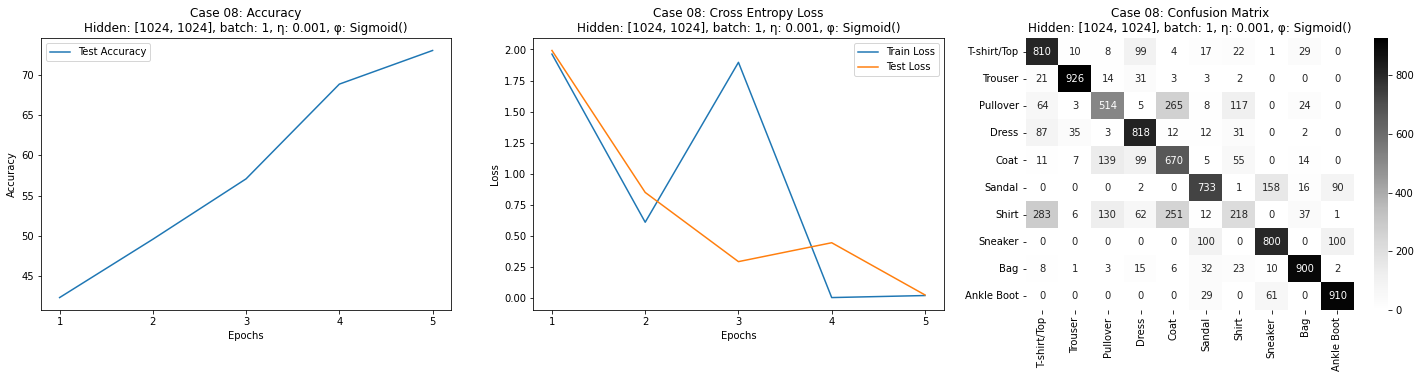

CASE: 09
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 1
Activation:    ReLU()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 1.2339    Testing Loss: 8.1902    Testing Accuracy: 35.71%
Epoch 2/5  Training Loss: 1.2559    Testing Loss: 2.1372    Testing Accuracy: 31.18%
Epoch 3/5  Training Loss: 2.4201    Testing Loss: 1.9372    Testing Accuracy: 19.57%
Epoch 4/5  Training Loss: 1.6302    Testing Loss: 1.6193    Testing Accuracy: 33.31%
Epoch 5/5  Training Loss: 2.0901    Testing Loss: 1.8126    Testing Accuracy: 27.08%


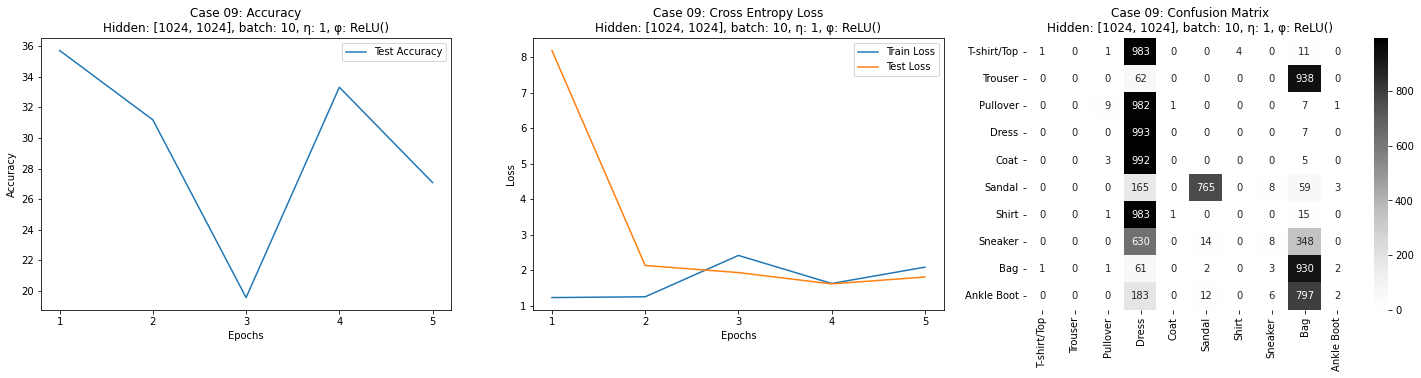

CASE: 10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.3339    Testing Loss: 0.0976    Testing Accuracy: 85.46%
Epoch 2/5  Training Loss: 0.0578    Testing Loss: 0.2218    Testing Accuracy: 87.13%
Epoch 3/5  Training Loss: 0.1149    Testing Loss: 0.5921    Testing Accuracy: 86.97%
Epoch 4/5  Training Loss: 0.2464    Testing Loss: 0.3134    Testing Accuracy: 88.56%
Epoch 5/5  Training Loss: 0.4800    Testing Loss: 0.0705    Testing Accuracy: 88.79%


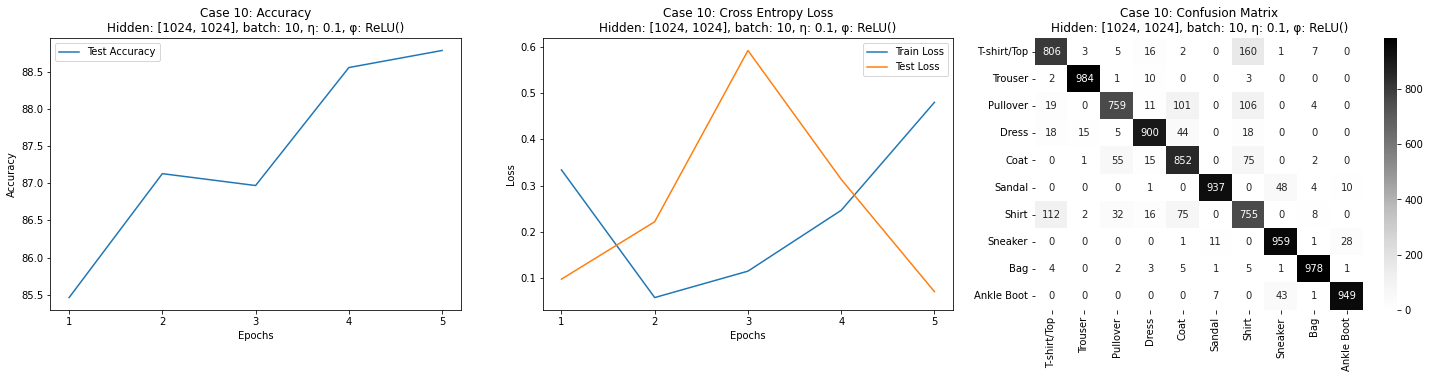

CASE: 11
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.2143    Testing Loss: 0.5602    Testing Accuracy: 84.38%
Epoch 2/5  Training Loss: 0.2926    Testing Loss: 0.0961    Testing Accuracy: 85.9%
Epoch 3/5  Training Loss: 0.0493    Testing Loss: 0.4580    Testing Accuracy: 86.69%
Epoch 4/5  Training Loss: 0.1779    Testing Loss: 0.4693    Testing Accuracy: 87.22%
Epoch 5/5  Training Loss: 0.4204    Testing Loss: 0.0113    Testing Accuracy: 87.51%


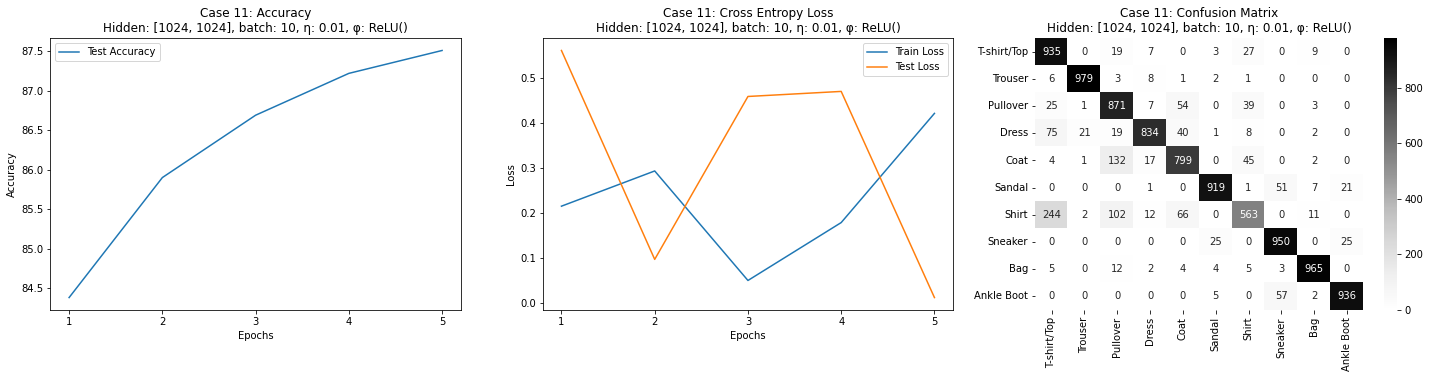

CASE: 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.9370    Testing Loss: 0.4339    Testing Accuracy: 74.81%
Epoch 2/5  Training Loss: 0.5871    Testing Loss: 0.3616    Testing Accuracy: 78.95%
Epoch 3/5  Training Loss: 0.3616    Testing Loss: 0.3139    Testing Accuracy: 81.38%
Epoch 4/5  Training Loss: 0.4312    Testing Loss: 0.7391    Testing Accuracy: 82.43%
Epoch 5/5  Training Loss: 0.4436    Testing Loss: 0.9098    Testing Accuracy: 83.24%


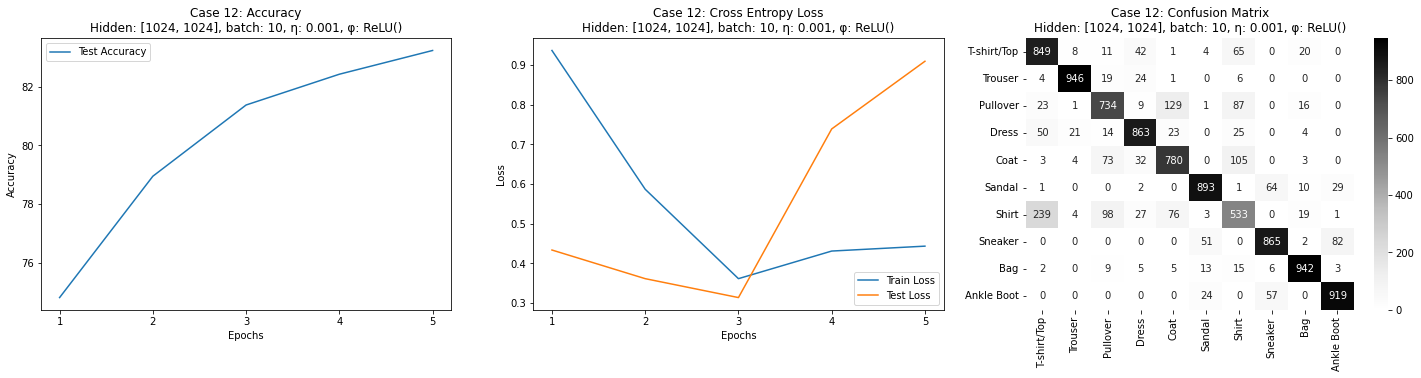

CASE: 13
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.4762    Testing Loss: 0.6333    Testing Accuracy: 83.95%
Epoch 2/5  Training Loss: 0.0504    Testing Loss: 0.3798    Testing Accuracy: 84.94%
Epoch 3/5  Training Loss: 0.5461    Testing Loss: 0.0488    Testing Accuracy: 86.93%
Epoch 4/5  Training Loss: 0.7563    Testing Loss: 0.1887    Testing Accuracy: 87.39%
Epoch 5/5  Training Loss: 0.4215    Testing Loss: 0.6686    Testing Accuracy: 87.23%


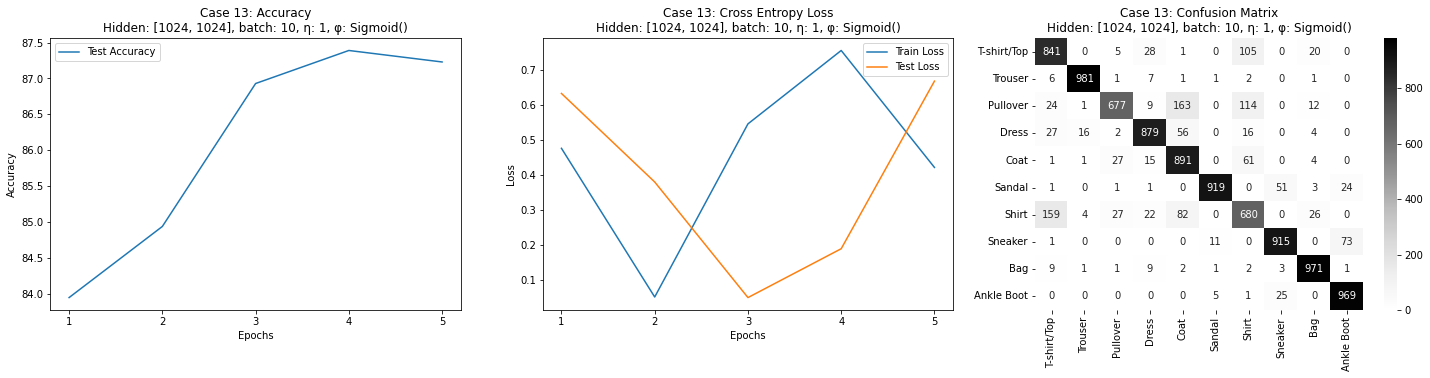

CASE: 14
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.2624    Testing Loss: 0.2639    Testing Accuracy: 82.09%
Epoch 2/5  Training Loss: 0.3627    Testing Loss: 0.3652    Testing Accuracy: 84.62%
Epoch 3/5  Training Loss: 0.1977    Testing Loss: 0.4663    Testing Accuracy: 85.55%
Epoch 4/5  Training Loss: 0.7362    Testing Loss: 0.4844    Testing Accuracy: 87.12%
Epoch 5/5  Training Loss: 0.3625    Testing Loss: 0.1670    Testing Accuracy: 87.62%


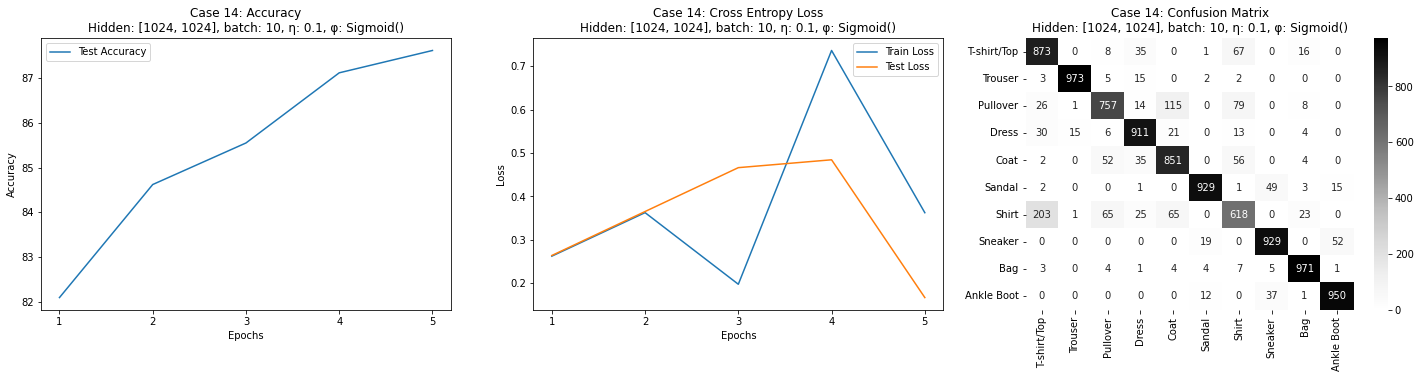

CASE: 15
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.8916    Testing Loss: 1.1579    Testing Accuracy: 64.79%
Epoch 2/5  Training Loss: 0.4265    Testing Loss: 0.5759    Testing Accuracy: 72.31%
Epoch 3/5  Training Loss: 0.4120    Testing Loss: 0.1646    Testing Accuracy: 79.08%
Epoch 4/5  Training Loss: 0.2514    Testing Loss: 0.1897    Testing Accuracy: 80.06%
Epoch 5/5  Training Loss: 0.5164    Testing Loss: 0.0878    Testing Accuracy: 81.63%


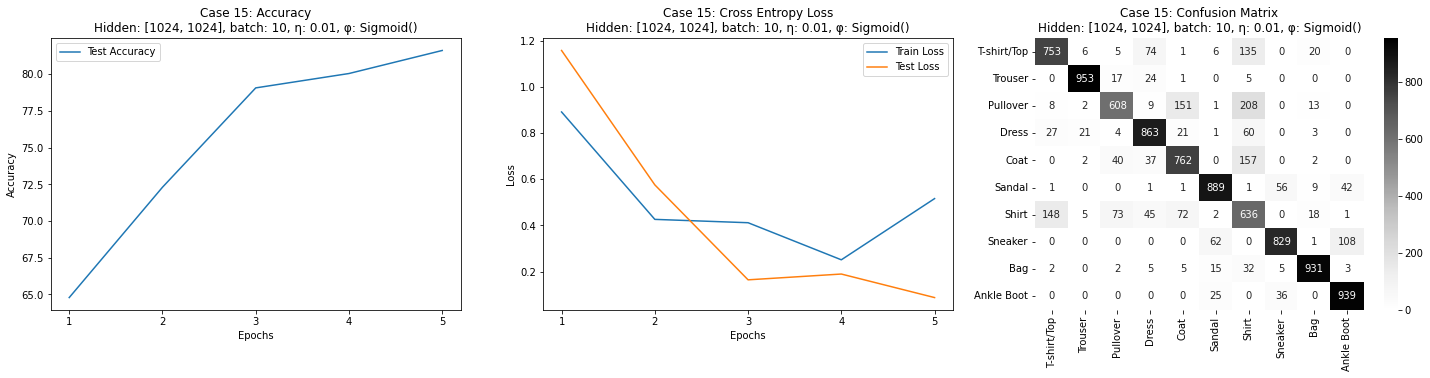

CASE: 16
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 2.2206    Testing Loss: 2.2633    Testing Accuracy: 16.19%
Epoch 2/5  Training Loss: 2.1339    Testing Loss: 2.1739    Testing Accuracy: 47.55%
Epoch 3/5  Training Loss: 1.9020    Testing Loss: 1.9008    Testing Accuracy: 43.57%
Epoch 4/5  Training Loss: 1.6717    Testing Loss: 1.5311    Testing Accuracy: 53.7%
Epoch 5/5  Training Loss: 1.6061    Testing Loss: 1.4605    Testing Accuracy: 60.13%


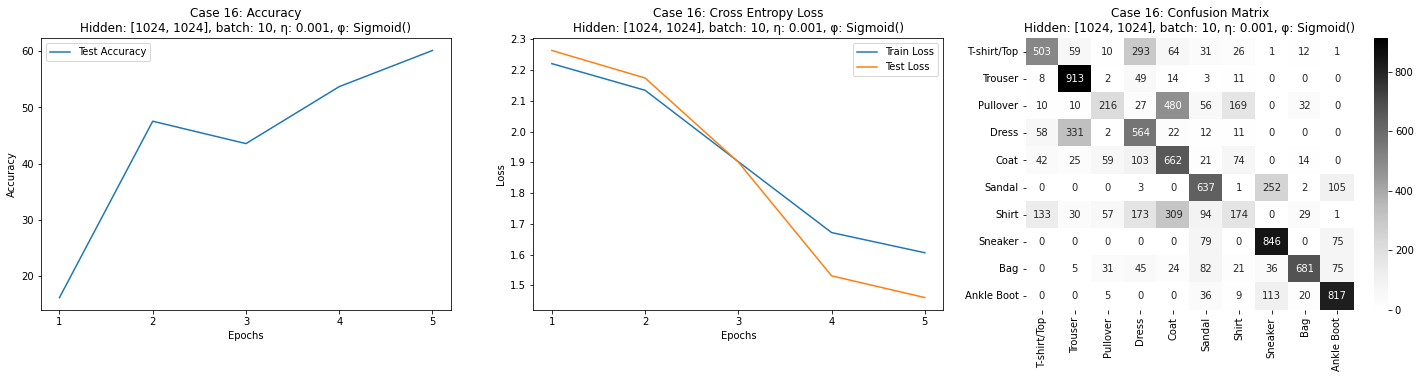

CASE: 17
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 1
Activation:    ReLU()
Batch Size:    1000
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.6255    Testing Loss: 0.6666    Testing Accuracy: 74.22%
Epoch 2/5  Training Loss: 0.5446    Testing Loss: 0.6235    Testing Accuracy: 76.3%
Epoch 3/5  Training Loss: 0.4399    Testing Loss: 0.4357    Testing Accuracy: 82.78%
Epoch 4/5  Training Loss: 0.4200    Testing Loss: 0.3323    Testing Accuracy: 85.78%
Epoch 5/5  Training Loss: 0.3594    Testing Loss: 0.3768    Testing Accuracy: 86.82%


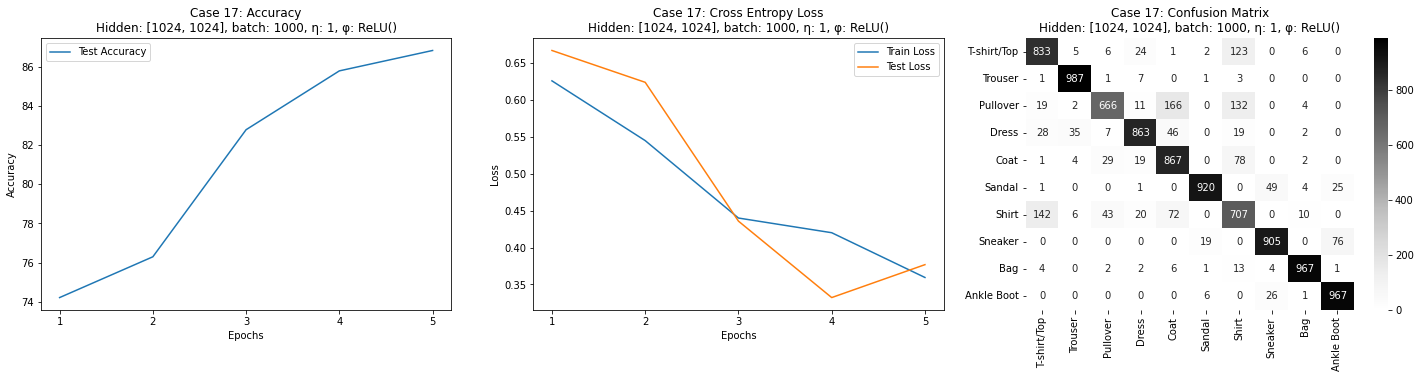

CASE: 18
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    1000
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.6090    Testing Loss: 0.6159    Testing Accuracy: 78.38%
Epoch 2/5  Training Loss: 0.5255    Testing Loss: 0.5596    Testing Accuracy: 80.18%
Epoch 3/5  Training Loss: 0.5635    Testing Loss: 0.5712    Testing Accuracy: 80.07%
Epoch 4/5  Training Loss: 0.4856    Testing Loss: 0.4244    Testing Accuracy: 83.85%
Epoch 5/5  Training Loss: 0.4949    Testing Loss: 0.4550    Testing Accuracy: 83.43%


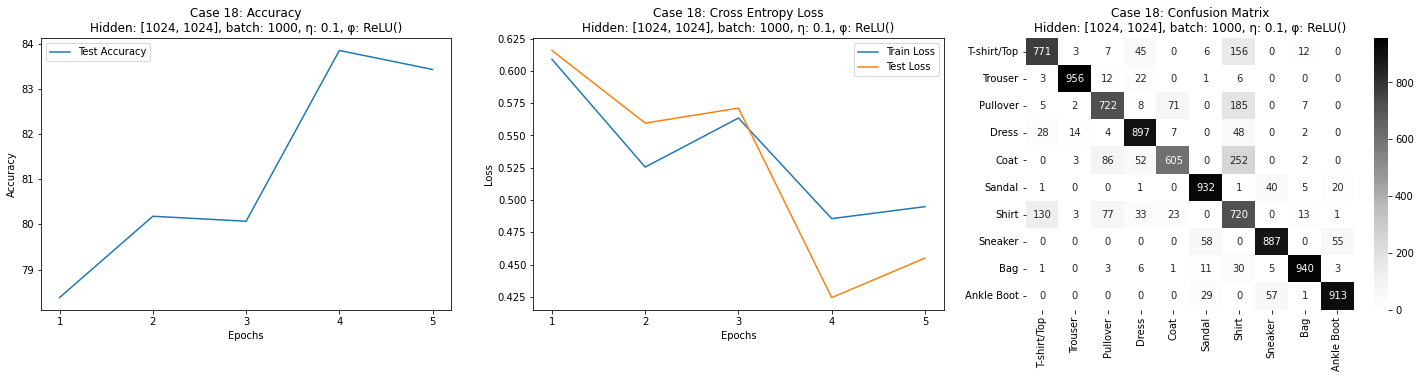

CASE: 19
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    1000
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 1.7133    Testing Loss: 1.6912    Testing Accuracy: 62.53%
Epoch 2/5  Training Loss: 1.2145    Testing Loss: 1.2190    Testing Accuracy: 68.9%
Epoch 3/5  Training Loss: 0.9625    Testing Loss: 0.9532    Testing Accuracy: 71.85%
Epoch 4/5  Training Loss: 0.8668    Testing Loss: 0.8531    Testing Accuracy: 73.39%
Epoch 5/5  Training Loss: 0.7422    Testing Loss: 0.7484    Testing Accuracy: 74.84%


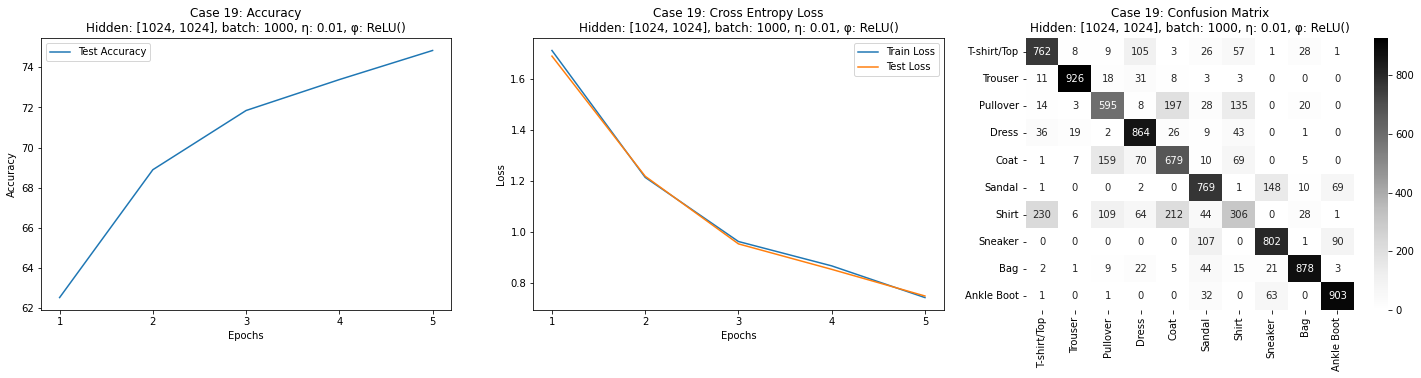

CASE: 20
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    1000
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 2.2378    Testing Loss: 2.2364    Testing Accuracy: 29.43%
Epoch 2/5  Training Loss: 2.1846    Testing Loss: 2.1768    Testing Accuracy: 38.14%
Epoch 3/5  Training Loss: 2.1195    Testing Loss: 2.1284    Testing Accuracy: 43.09%
Epoch 4/5  Training Loss: 2.0692    Testing Loss: 2.0675    Testing Accuracy: 46.48%
Epoch 5/5  Training Loss: 2.0180    Testing Loss: 2.0020    Testing Accuracy: 49.84%


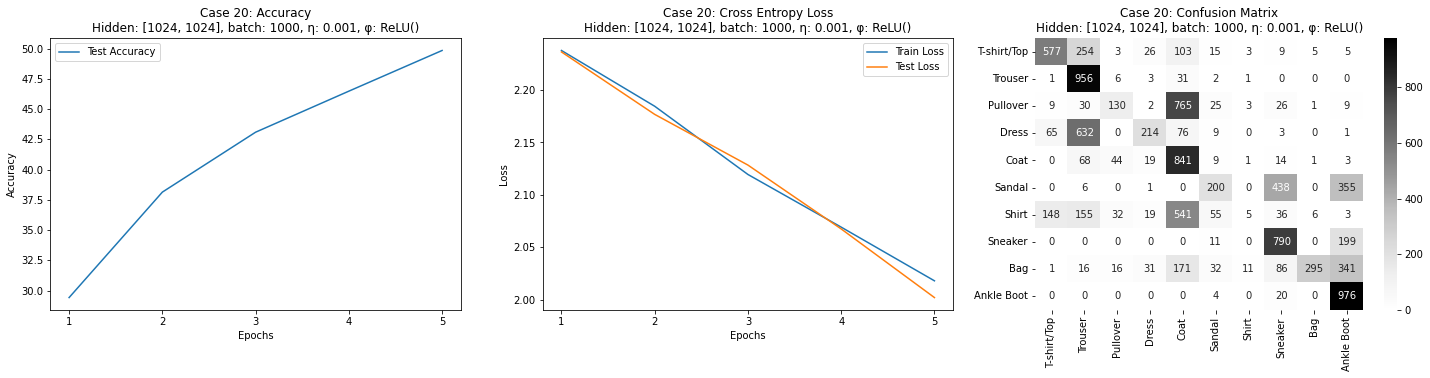

CASE: 21
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 1.2964    Testing Loss: 1.1710    Testing Accuracy: 57.21%
Epoch 2/5  Training Loss: 0.8794    Testing Loss: 0.8803    Testing Accuracy: 66.44%
Epoch 3/5  Training Loss: 0.6733    Testing Loss: 0.7075    Testing Accuracy: 70.95%
Epoch 4/5  Training Loss: 0.6306    Testing Loss: 0.7015    Testing Accuracy: 73.46%
Epoch 5/5  Training Loss: 0.5988    Testing Loss: 0.5714    Testing Accuracy: 77.35%


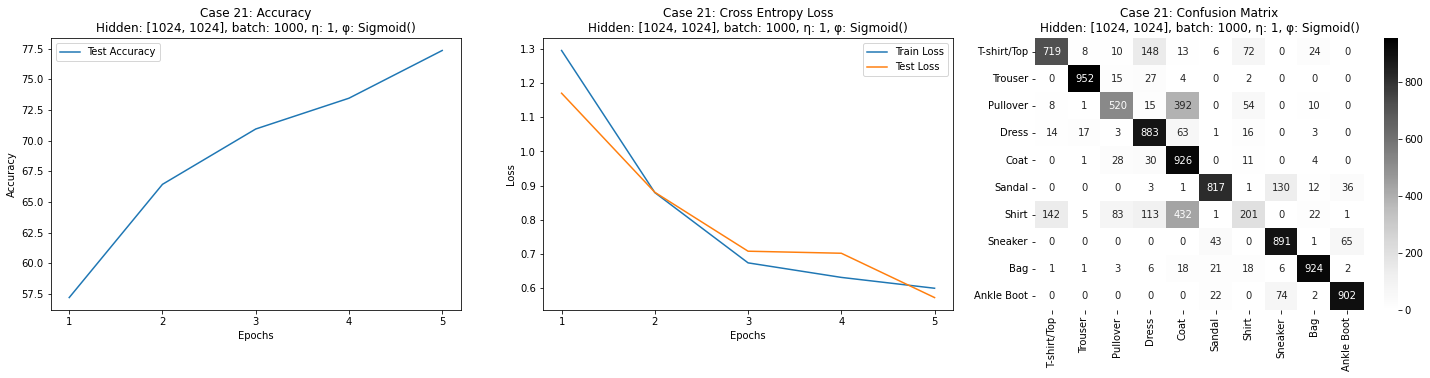

CASE: 22
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 2.2754    Testing Loss: 2.2153    Testing Accuracy: 21.22%
Epoch 2/5  Training Loss: 1.7127    Testing Loss: 1.7135    Testing Accuracy: 32.68%
Epoch 3/5  Training Loss: 1.3018    Testing Loss: 1.3444    Testing Accuracy: 48.42%
Epoch 4/5  Training Loss: 1.1364    Testing Loss: 1.1751    Testing Accuracy: 58.79%
Epoch 5/5  Training Loss: 1.0258    Testing Loss: 1.0256    Testing Accuracy: 58.38%


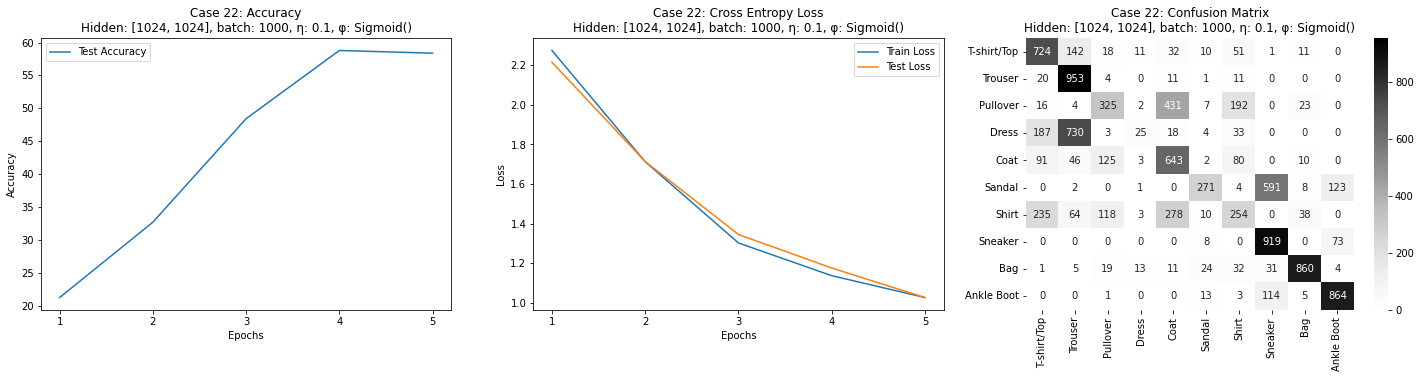

CASE: 23
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 2.2888    Testing Loss: 2.2884    Testing Accuracy: 14.95%
Epoch 2/5  Training Loss: 2.2773    Testing Loss: 2.2745    Testing Accuracy: 32.18%
Epoch 3/5  Training Loss: 2.2631    Testing Loss: 2.2630    Testing Accuracy: 47.48%
Epoch 4/5  Training Loss: 2.2475    Testing Loss: 2.2514    Testing Accuracy: 49.39%
Epoch 5/5  Training Loss: 2.2322    Testing Loss: 2.2316    Testing Accuracy: 46.23%


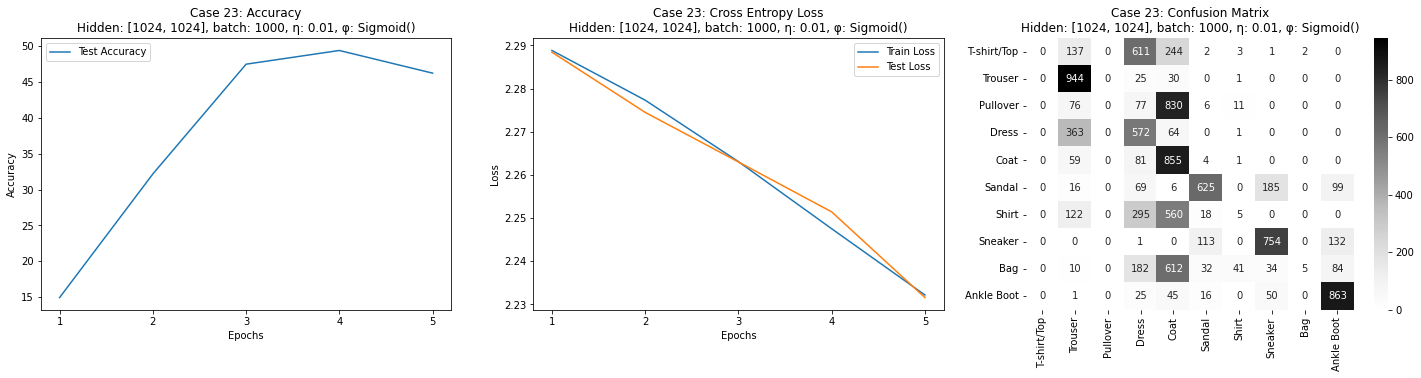

CASE: 24
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 2.3034    Testing Loss: 2.3038    Testing Accuracy: 9.03%
Epoch 2/5  Training Loss: 2.3011    Testing Loss: 2.3019    Testing Accuracy: 15.51%
Epoch 3/5  Training Loss: 2.2991    Testing Loss: 2.2995    Testing Accuracy: 17.64%
Epoch 4/5  Training Loss: 2.2982    Testing Loss: 2.2987    Testing Accuracy: 17.46%
Epoch 5/5  Training Loss: 2.2968    Testing Loss: 2.2969    Testing Accuracy: 25.33%


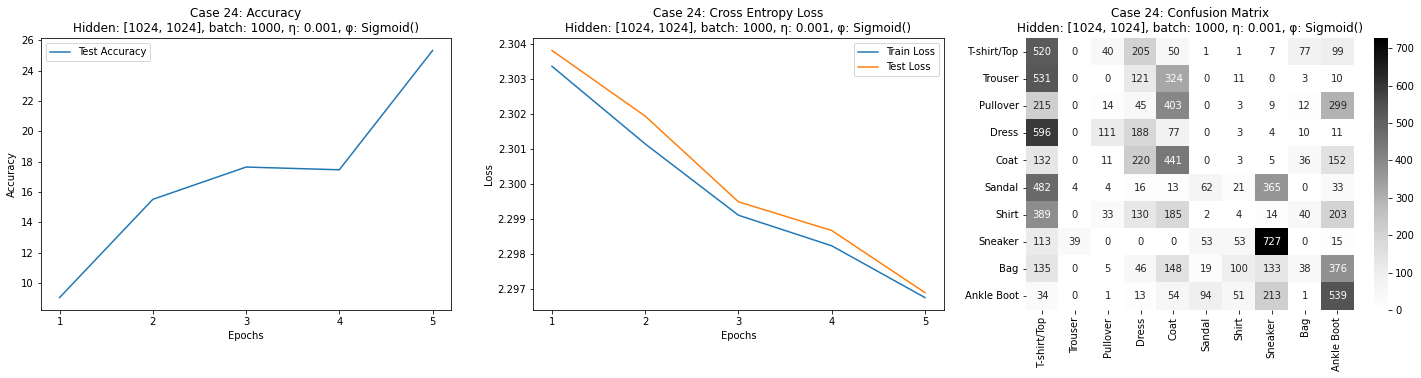

In [16]:
hidden_size = [1024, 1024]
momentum = 0
epochs = 5

params = {
    'batch_size': [1, 10, 1000],
    'activation': [nn.ReLU(), nn.Sigmoid()],
    'learn_rate': [1, 0.1, 0.01, 0.001],
}

i = 0
for batch_size in params['batch_size']:
    for activation in params['activation']:
        for learn_rate in params['learn_rate']:
            i += 1

            print(f"CASE: {i:02d}")
            print("~"*85)

            model = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
            model.train(hidden_size=hidden_size, activation=activation, 
                        learn_rate=learn_rate, momentum=momentum, epochs=epochs)

            display_model_visuals(model=model, hidden_size=hidden_size, title=f"Case {i:02d}");

##Data Pollution

Pick 9 sets of 1% of images from each of the 10 categories and add them to the other 9 categories.

In [17]:
# pollute the data as stated
data_train = pd.read_csv(train_file_path)

df_pollution = pd.DataFrame()
df_duplicate = pd.DataFrame()
df_concat = pd.DataFrame()

for i in range(10):
    df = data_train.loc[data_train.label == i]
    df = df.sample(frac=0.1)
    for j in range(10):
        if j==i:
            continue
        df.label = j
        df_pollution = df_pollution.append(df)
        df_duplicate = df_duplicate.append(df)

df_concat = df_pollution.append(data_train)

# remove duplicates
df_polluted = pd.merge(df_concat, df_duplicate, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
df_polluted

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
54000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54001,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54002,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
54003,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
54004,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
113996,1,0,0,0,0,0,0,0,0,0,0,83,155,136,116,148,110,118,67,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,118,...,199,165,108,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,159,6,91,0,0,85,159,0,73,0,0,0,0,0,0,0,0,0
113997,8,0,0,0,0,0,0,0,0,0,0,1,0,0,87,114,77,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,...,228,229,231,231,218,230,255,0,0,0,0,0,0,0,0,0,0,0,116,140,147,166,176,174,173,173,174,173,177,164,160,162,163,135,94,0,0,0,0,0
113998,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
# normalize the data and loading them for our model

mean = np.array(df_polluted.iloc[:,1:]).flatten().mean()
std  = np.array(df_polluted.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_train_polluted = FashionMNIST(df_polluted, transform=transf)

## Experiment 4 [Qn 4]

Hidden Layers: [1024, 1024]
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.7611    Testing Loss: 0.0001    Testing Accuracy: 86.51%
Epoch 2/5  Training Loss: 0.0000    Testing Loss: 0.0022    Testing Accuracy: 86.7%
Epoch 3/5  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 86.05%
Epoch 4/5  Training Loss: 0.0000    Testing Loss: 0.0060    Testing Accuracy: 88.11%
Epoch 5/5  Training Loss: 0.0000    Testing Loss: 0.0070    Testing Accuracy: 88.13%


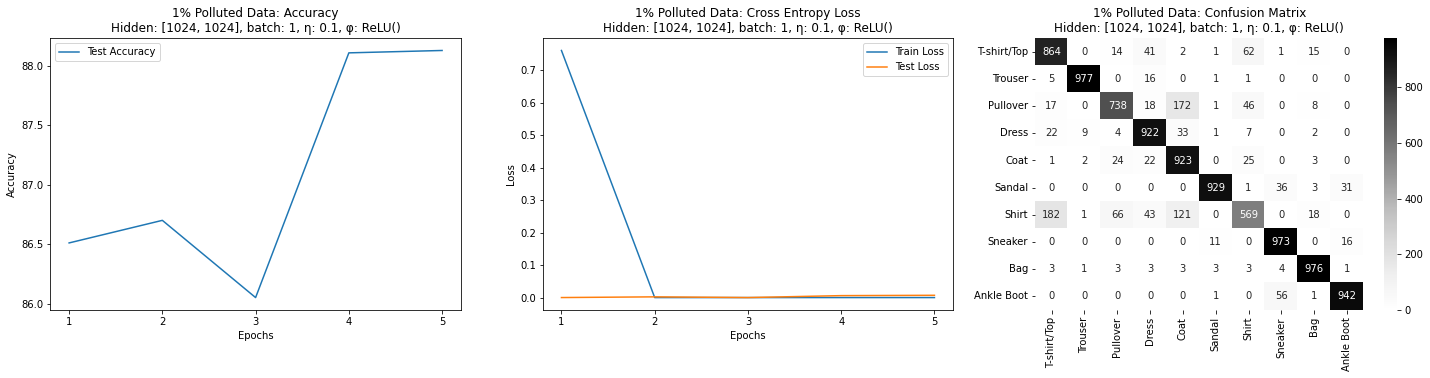

In [19]:
hidden_size = [1024, 1024]
batch_size = 1
learn_rate = 0.1
activation = nn.ReLU()
momentum = 0
epochs = 5

model_polluted = FashionModel(data_train=data_train_polluted, data_test=data_test, batch_size=batch_size)
model_polluted.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

display_model_visuals(model=model_polluted, hidden_size=hidden_size, title="1% Polluted Data")

## Circular Shift

In [11]:
data_test = pd.read_csv(test_file_path)

def shift_right(n):
    right_cols = data_test.iloc[:, -2:]
    left_cols = data_test.iloc[:, 1:-2]
    shifted = pd.concat([right_cols, left_cols], axis=1)
    # shifted = pd.concat([right_cols, left_cols.reindex(right_cols.index)], axis=1)
    shifted.columns = data_test.columns[1:]
    shifted.insert(loc=0, column='label', value=data_test.label)
    return shifted

In [12]:
shifted_df = shift_right(2)
shifted_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,...,232,236,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,87,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,...,0,0,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0
3,2,0,0,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,...,255,255,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56
4,3,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,...,2,70,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,0,0,37,93,72,58,55,63,66,89,159,120,20,0,0,0,0,1,0,0,0,0,0,0,1,0,0,22,67,125,...,124,112,112,115,117,117,113,146,41,0,3,0,0,0,0,0,0,0,1,0,1,76,54,55,51,53,53,55,53,44,38,37,32,23,14,20,0,0,1,0
9996,6,0,0,0,0,0,0,0,0,0,0,0,0,0,76,36,110,170,78,136,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,110,86,94,84,70,44,0,36,152,65,110,0,0,0,0,0,0,0,21,57,89,7,0,0,0,0,0,0,0,0,0,0,0,0,0,2,52,23,28,0
9997,8,1,0,0,0,0,0,0,0,0,0,0,0,1,3,0,14,152,184,158,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,213,214,219,223,226,239,247,241,224,213,144,0,0,0,0,0,0,1,0,44,232,199,200,190,180,179,185,189,191,185,179,178,175,172,172,182,199,222,42,0
9998,8,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,131,192,79,0,0,...,219,77,13,26,17,8,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


## Experiment 5 [Qn 5]

Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.8340    Testing Loss: 1.3941    Testing Accuracy: 57.35%
Epoch 2/5  Training Loss: 0.7959    Testing Loss: 0.9382    Testing Accuracy: 59.28%
Epoch 3/5  Training Loss: 0.5644    Testing Loss: 1.1577    Testing Accuracy: 60.57%
Epoch 4/5  Training Loss: 0.4523    Testing Loss: 1.0972    Testing Accuracy: 61.73%
Epoch 5/5  Training Loss: 0.7418    Testing Loss: 1.1049    Testing Accuracy: 61.2%


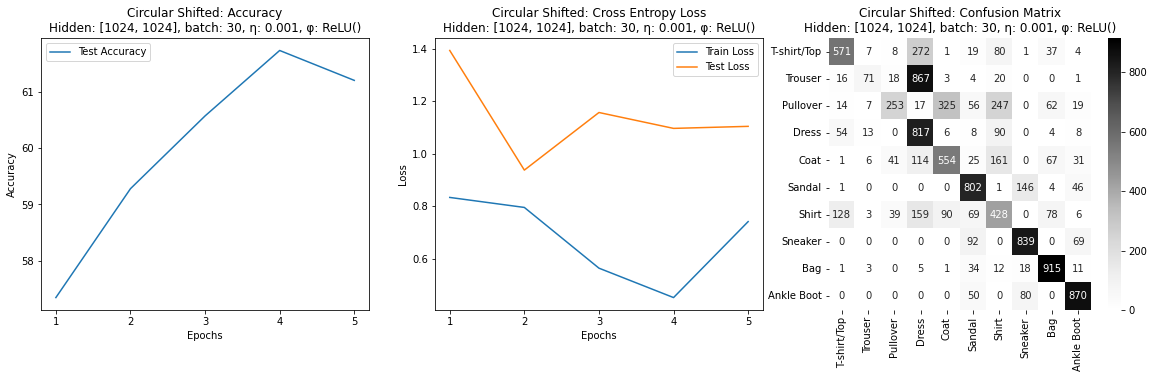

In [18]:
# normalize the data and loading them for our model
mean = np.array(data.iloc[:,1:]).flatten().mean()
std  = np.array(data.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_train = pd.read_csv(train_file_path)
data_test  = FashionMNIST(shifted_df,transform=transf)
data_train = FashionMNIST(data_train,transform=transf)

# Although it looks like I am doing training here, I am not training on the shifted dataset, 
# I am sure I am testing on the shifted dataset. I am testing on all epochs.

hidden_size = [1024, 1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 5

model_2 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_2.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

display_model_visuals(model=model_2, hidden_size=hidden_size, title="Circular Shifted")

## Down Shift

In [19]:
data_test = pd.read_csv(test_file_path)

def shift_down(n):
    down_shifted = data_test.shift(periods=2)
    top_rows = data_test[:2]
    for i in range(2):
        down_shifted.loc[i] = top_rows.loc[i]
    return down_shifted

In [20]:
shifted_df = shift_down(2)
shifted_df = shifted_df.astype(int)
shifted_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,1,0,2,0,0,110,63,60,97,39,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,17,...,156,165,171,154,164,91,0,3,1,0,0,0,0,0,0,1,1,0,0,94,97,100,102,94,89,89,89,86,88,86,85,67,114,51,0,1,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,37,93,72,58,55,63,66,89,159,120,20,0,0,0,0,1,0,0,0,0,0,0,1,0,0,22,67,125,151,168,...,112,115,117,117,113,146,41,0,3,0,0,0,0,0,0,0,1,0,1,76,54,55,51,53,53,55,53,44,38,37,32,23,14,20,0,0,1,0,0,0
9998,6,0,0,0,0,0,0,0,0,0,0,0,76,36,110,170,78,136,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,...,94,84,70,44,0,36,152,65,110,0,0,0,0,0,0,0,21,57,89,7,0,0,0,0,0,0,0,0,0,0,0,0,0,2,52,23,28,0,0,0


## Experiment 6 [Qn 5]

Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.7603    Testing Loss: 0.7881    Testing Accuracy: 71.4%
Epoch 2/5  Training Loss: 0.7369    Testing Loss: 0.8666    Testing Accuracy: 75.4%
Epoch 3/5  Training Loss: 0.5553    Testing Loss: 0.7560    Testing Accuracy: 78.29%
Epoch 4/5  Training Loss: 0.4521    Testing Loss: 0.7303    Testing Accuracy: 79.55%
Epoch 5/5  Training Loss: 0.6287    Testing Loss: 0.4193    Testing Accuracy: 80.81%


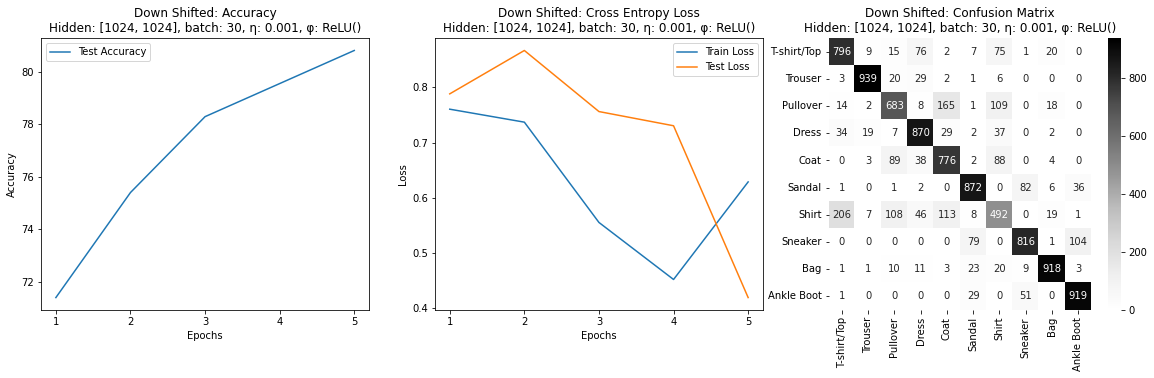

In [21]:
# normalize the data and loading them for our model
mean = np.array(data.iloc[:,1:]).flatten().mean()
std  = np.array(data.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_train = pd.read_csv(train_file_path)
data_test  = FashionMNIST(shifted_df,transform=transf)
data_train = FashionMNIST(data_train,transform=transf)


hidden_size = [1024, 1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 5

model_2 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_2.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)
display_model_visuals(model=model_2, hidden_size=hidden_size, title="Down Shifted")